In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble 
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


nlp = spacy.load('en')


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df_all = pd.read_csv(r'C:\Users\julia\Dropbox\Data Science 2\Petfinder\train.csv')
df_text=df_all[['AdoptionSpeed','Description']]
df_text=df_text.dropna()
df_text.groupby('AdoptionSpeed').count()

,Description
AdoptionSpeed,
0,410
1,3088
2,4032
3,3258
4,4193


In [4]:
df_text['AdoptionSpeed'].replace(0,1,inplace=True)
df_text.groupby('AdoptionSpeed').count()

,Description
AdoptionSpeed,
1,3498
2,4032
3,3258
4,4193


In [5]:
df_all.dropna().shape

(13724, 24)

In [6]:
df_all.shape

(14993, 24)

In [7]:
index=df_all['Description'].index[df_all['Description'].apply(pd.isnull)]
df_all.drop(index,0,inplace=True)
df_all.shape

(14981, 24)

In [8]:
corpus = []
for i, description in enumerate(df_text['Description']):
    desc = re.sub('[^a-zA-Z]',' ',description)
    desc = desc.lower()
    desc = desc.split()
    desc = [word for word in desc if not word in set(stopwords.words('english'))]
    desc = ' '.join(desc)
    corpus.append(desc)

df_text = df_text.join(pd.DataFrame({'clean':corpus}))

In [10]:
temp=[]
for i, desc in enumerate(df_text['clean']):
#for i in range(90,100):
    desc = df_text['Description'].iloc[i]
    temp.append(nlp(desc))

In [11]:
df_text= df_text.join(pd.DataFrame({'NLP':temp}))

In [18]:
df_text.dropna(inplace=True)

In [25]:
#BoW
cv = CountVectorizer(max_features=2000)
X_bow = cv.fit_transform(df_text['clean']).toarray()
y_bow = df_text.iloc[:,0].values
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow,y_bow,test_size=0.25)

In [22]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
km.fit(X_bow)
clusters = km.labels_.tolist()
df_text['cluster']= clusters
df_text['cluster'].value_counts() 

2    11535
1     2176
0     1225
3       33
Name: cluster, dtype: int64

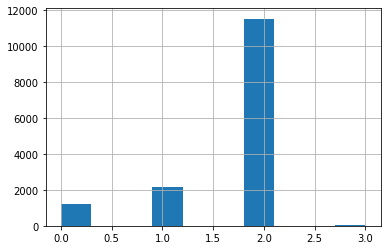

In [23]:
df_text['cluster'].hist()

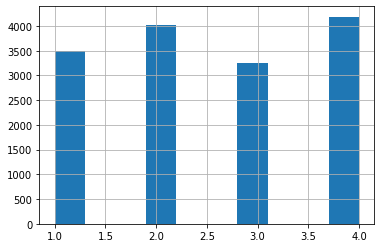

In [24]:
df_text['AdoptionSpeed'].hist()

In [26]:
sc=StandardScaler()
X_bow_std = sc.fit_transform(X_bow)

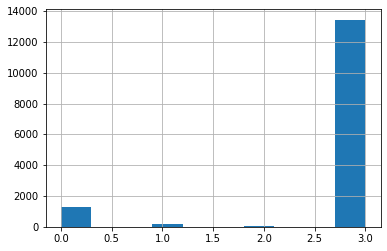

In [27]:
km.fit(X_bow_std)
clusters = km.labels_.tolist()
df_text['cluster']= clusters
df_text['cluster'].value_counts() 
df_text['cluster'].hist()

In [28]:
vectorizer = TfidfVectorizer()
X_tfidf=vectorizer.fit_transform(df_text['Description'])
y=df_text.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

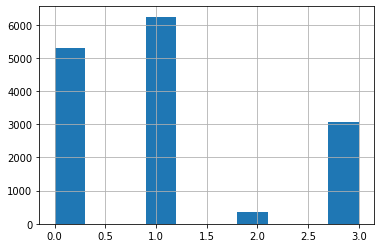

In [29]:
km.fit(X_tfidf)
clusters = km.labels_.tolist()
df_text['cluster tfidf']= clusters
df_text['cluster tfidf'].hist()

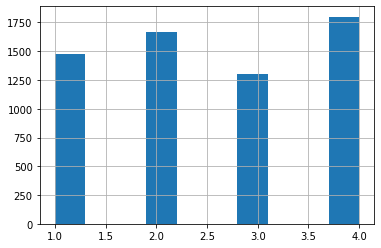

In [31]:
df_text[df_text['cluster tfidf']==1]['AdoptionSpeed'].hist()

In [88]:
confusion_matrix(y,df_text['cluster'])

array([[   0,    0,    0,    0,    0],
       [ 343,   45,    4, 3105,    0],
       [ 336,   51,    7, 3636,    0],
       [ 291,   38,    7, 2917,    0],
       [ 330,   71,    9, 3779,    0]], dtype=int64)

In [90]:
from sklearn import metrics
metrics.adjusted_rand_score(y, df_text['cluster'])
metrics.silhouette_score(y.reshape(-1, 1),df_text['cluster'])

-0.08581608570803066

In [32]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_bow, y_train_bow)
y_pred = rfc.predict(X_test_bow)
print(rfc.score(X_test_bow, y_test_bow))
print(confusion_matrix(y_pred,y_test_bow))

0.2508682874699439
[[225 244 227 266]
 [267 273 269 331]
 [149 159 134 168]
 [236 281 207 307]]


In [33]:
rfc.fit(X_train_tfidf, y_train_tfidf)
y_pred = rfc.predict(X_test_tfidf)
print(rfc.score(X_test_tfidf, y_test_tfidf))
print(confusion_matrix(y_pred,y_test_tfidf))

0.3574672722415175
[[304 264 183 231]
 [251 360 224 261]
 [107 142 194  99]
 [213 235 195 480]]


In [34]:
df_1=df_text[df_text['AdoptionSpeed']==1].copy()
df_2=df_text[df_text['AdoptionSpeed']==2].copy()
df_3=df_text[df_text['AdoptionSpeed']==3].copy()
df_4=df_text[df_text['AdoptionSpeed']==4].copy()

df_1.dropna(inplace=True)
df_2.dropna(inplace=True)
df_3.dropna(inplace=True)
df_4.dropna(inplace=True)

In [35]:
cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_1 = cv.fit_transform(df_1.clean)
data_dtm_1 = pd.DataFrame(data_cv_1.toarray(), columns=cv.get_feature_names())
data_dtm_1.index = df_1.index

cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_2 = cv.fit_transform(df_2.clean)
data_dtm_2 = pd.DataFrame(data_cv_2.toarray(), columns=cv.get_feature_names())
data_dtm_2.index = df_2.index

cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_3 = cv.fit_transform(df_3.clean)
data_dtm_3 = pd.DataFrame(data_cv_3.toarray(), columns=cv.get_feature_names())
data_dtm_3.index = df_3.index

cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_4 = cv.fit_transform(df_4.clean)
data_dtm_4 = pd.DataFrame(data_cv_4.toarray(), columns=cv.get_feature_names())
data_dtm_4.index = df_4.index


In [36]:
top1 = data_dtm_1.sum().sort_values(ascending=False).head(25)
top2 = data_dtm_2.sum().sort_values(ascending=False).head(25)
top3 = data_dtm_3.sum().sort_values(ascending=False).head(25)
top4 = data_dtm_4.sum().sort_values(ascending=False).head(25)

In [38]:
top_words1 = list(top1.index)
top_words2 = list(top2.index)
top_words3 =list(top3.index)
top_words4 = list(top4.index)

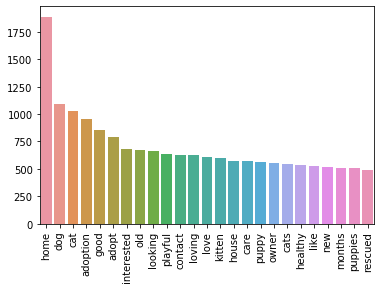

In [45]:
sns.barplot(x=top_words1,y=top1)
plt.xticks(rotation='vertical')
plt.show()

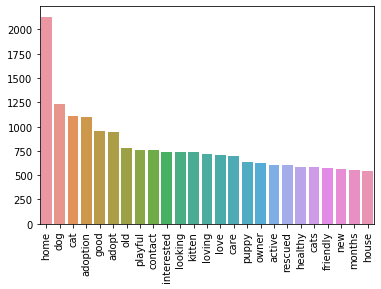

In [46]:
sns.barplot(x=top_words2,y=top2)
plt.xticks(rotation='vertical')
plt.show()

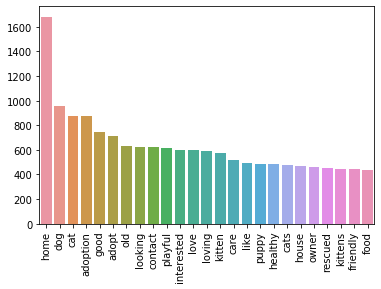

In [47]:
sns.barplot(x=top_words3,y=top3)
plt.xticks(rotation='vertical')
plt.show()

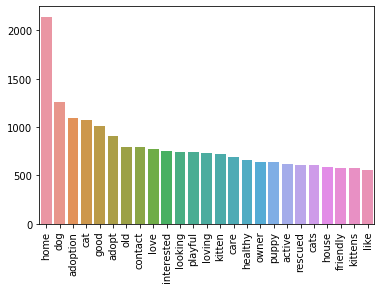

In [48]:
sns.barplot(x=top_words4,y=top4)
plt.xticks(rotation='vertical')
plt.show()

In [49]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 34.66522182330311


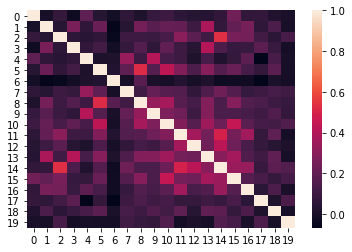

In [52]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:20,0:20]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(20))
plt.show()

In [55]:
df_text['Description'].iloc[8]

"healthy and active, feisty kitten found in neighbours' garden. Not sure of sex."

In [56]:
df_text['Description'].iloc[5]

'This is a stray kitten that came to my house. Have been feeding it, but cannot keep it.'

In [57]:
df_text['AdoptionSpeed'].iloc[8]

1

In [59]:
df_text['AdoptionSpeed'].iloc[5]

2

In [61]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5,random_state=42)
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(df_text['clean'])

In [62]:
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [63]:
len(LDA.components_)

5

In [64]:
topic_results = LDA.transform(dtm)

In [66]:
df_text['Topic'] = topic_results.argmax(axis=1)

In [75]:
top_word_indices = LDA.components_[0].argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names()[index])

time
cat
food
like
playful
little
old
kitten
home
loves


In [77]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['play', 'months', 'love', 'adoption', 'cats', 'time', 'cat', 'food', 'like', 'playful', 'little', 'old', 'kitten', 'home', 'loves']


THE TOP 15 WORDS FOR TOPIC #1
['nak', 'tak', 'ada', 'anak', 'boleh', 'manja', 'yg', 'ni', 'untuk', 'di', 'yang', 'dia', 'dan', 'kucing', 'saya']


THE TOP 15 WORDS FOR TOPIC #2
['good', 'cute', 'rescued', 'pls', 'female', 'dog', 'looking', 'old', 'adopt', 'interested', 'puppies', 'contact', 'adoption', 'puppy', 'home']


THE TOP 15 WORDS FOR TOPIC #3
['like', 'need', 'adoption', 'mother', 'new', 'love', 'food', 'adopt', 'house', 'care', 'kitten', 'cats', 'home', 'kittens', 'cat']


THE TOP 15 WORDS FOR TOPIC #4
['active', 'loves', 'needs', 'playful', 'family', 'new', 'looking', 'love', 'friendly', 'dogs', 'owner', 'loving', 'good', 'home', 'dog']




In [78]:
nmf_model = NMF(n_components=4,random_state=42)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [79]:
top_word_indices = nmf_model.components_[0].argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names()[index])

time
family
puppies
adopt
owner
house
good
adoption
dogs
dog


In [81]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['discuss', '22feb', 'doesn', 'chat', 'asian', 'kembung', 'canine', 'ginko', '21bee', 'figo', 'considerate', 'cindy', '23am', 'boris', 'borang']


THE TOP 15 WORDS FOR TOPIC #1
['considerate', 'kill', 'kembung', 'eq', 'asian', 'frogs', 'distant', 'discuss', 'feb', 'ch', '23am', 'detailly', 'astley', 'detailed', 'associattion']


THE TOP 15 WORDS FOR TOPIC #2
['evo', 'lived', 'amounting', 'jonker', '1bulan', '60', 'eiyza', 'expressed', 'kucingi', 'blacks', 'list', 'blacktail', 'diajak', 'bersandar', 'helps']


THE TOP 15 WORDS FOR TOPIC #3
['ginko', 'habit', 'distinguish', 'feb', 'explanation', 'challa', '21bee', 'crush', 'doesn', 'gino', 'becermin', 'cindy', 'dmestic', 'dogma', 'condo']




In [83]:
df_text['Topic NMF']= topic_results.argmax(axis=1)

In [85]:
df_text[['Description','AdoptionSpeed', 'Topic NMF']].head(20)

,Description,AdoptionSpeed,Topic NMF
0,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,I just found it alone yesterday near my apartm...,1,3
2,Their pregnant mother was dumped by her irresp...,3,2
3,"Good guard dog, very alert, active, obedience ...",2,4
4,This handsome yet cute boy is up for adoption....,2,2
5,This is a stray kitten that came to my house. ...,2,3
6,anyone within the area of ipoh or taiping who ...,1,3
7,Siu Pak just give birth on 13/6/10 to 6puppies...,3,2
8,"healthy and active, feisty kitten found in nei...",1,3
9,"Very manja and gentle stray cat found, we woul...",4,3


In [67]:
from sklearn.svm import LinearSVC
svc=LinearSVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
svc.score(X_test, y_test)

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.24418915308576009

In [69]:
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [71]:
df_text['scores'] = df_text['Description'].apply(lambda review: sid.polarity_scores(review))
df_text['compound']  = df_text['scores'].apply(lambda score_dict: score_dict['compound'])

df_text.head()

,AdoptionSpeed,Description,clean,NLP,cluster,cluster tfidf,Topic,scores,compound
0,2,Nibble is a 3+ month old ball of cuteness. He ...,nibble month old ball cuteness energetic playf...,"(Nibble, is, a, 3, +, month, old, ball, of, cu...",3,0,0,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.9552
1,1,I just found it alone yesterday near my apartm...,found alone yesterday near apartment shaking b...,"(I, just, found, it, alone, yesterday, near, m...",3,1,3,"{'neg': 0.149, 'neu': 0.723, 'pos': 0.129, 'co...",0.1280
2,3,Their pregnant mother was dumped by her irresp...,pregnant mother dumped irresponsible owner roa...,"(Their, pregnant, mother, was, dumped, by, her...",3,0,2,"{'neg': 0.095, 'neu': 0.706, 'pos': 0.2, 'comp...",0.7650
3,2,"Good guard dog, very alert, active, obedience ...",good guard dog alert active obedience waiting ...,"(Good, guard, dog, ,, very, alert, ,, active, ...",3,1,4,"{'neg': 0.0, 'neu': 0.483, 'pos': 0.517, 'comp...",0.9538
4,2,This handsome yet cute boy is up for adoption....,handsome yet cute boy adoption playful pal see...,"(This, handsome, yet, cute, boy, is, up, for, ...",3,0,2,"{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'comp...",0.9880


In [73]:
X = np.array(df_text[['compound']])
y = df_text.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [74]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.2858669516430671

In [86]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
xgb.score(X_test, y_test)

0.2861341170184344